In [86]:
import sys
sys.path.append('..')

from utils import *
from data_utils import *
from metrics import *
from plots import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Testing dataset generation 

In [87]:
def eval(model, device, dataset_loader, debug, classification_report_flag = False):
    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(len(set(all_labels)))]))

    return acc


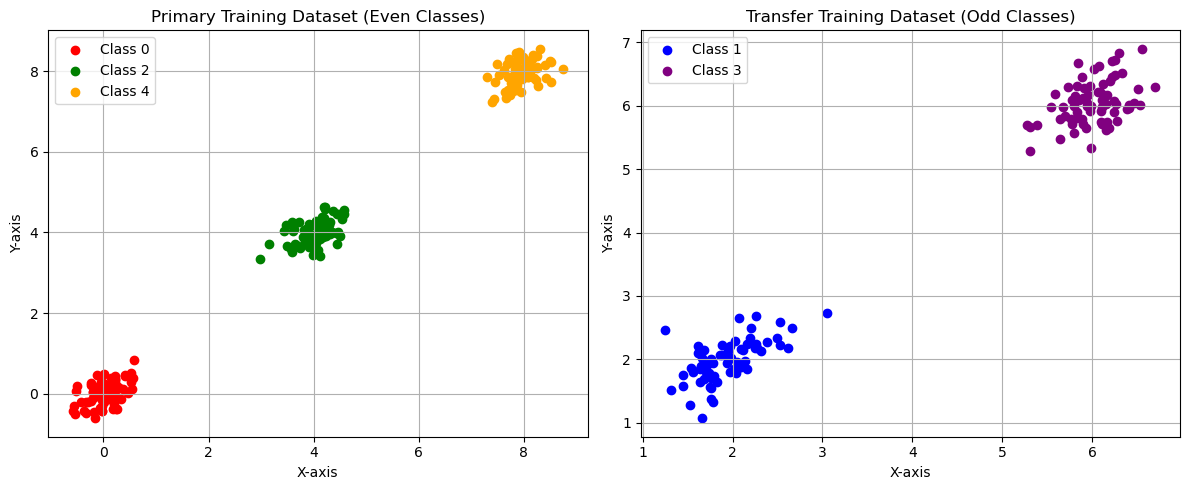

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_classes, n_points, base_covariance, shift, start_mean=0.0):
    """
    Generate synthetic data.
    
    Parameters:
        n_classes (int): The number of classes.
        n_points (int): The number of points per class.
        base_covariance (list of list of float): The base covariance matrix for generating points.
        shift (float): The shift in the mean for each subsequent class.
        
    Returns:
        X (np.ndarray): The feature array.
        y (np.ndarray): The label array.
    """
    
    X_list = []
    y_list = []
    
    for i in range(n_classes):
        # Mean for class i (shifted along the line y=x)
        mean = [start_mean + i * shift, start_mean + i * shift]
        
        # Generate points for class i
        x, y = np.random.multivariate_normal(mean, base_covariance, n_points).T
        
        # Labels for the points
        labels = np.full(n_points, i, dtype=int)
        
        X_list.append(np.column_stack((x, y)))
        y_list.append(labels)
        
    # Combine the points and labels
    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    
    # Shuffle the dataset
    shuffle_indices = np.random.permutation(n_classes * n_points)
    X = X[shuffle_indices]
    y = y[shuffle_indices]
    
    return X, y

# Seed for reproducibility
np.random.seed(42)

# Number of classes
n_classes = 5

# Number of points per class
n_points = 100

# Base covariance matrix for generating points
base_covariance = [[0.1, 0.05], [0.05, 0.1]]
#base_covariance = [[0.2, -0.19], [-0.19, 0.2]]

# Shift in mean for each subsequent class
shift = 2.0

# Generate the data
# Generate the data
X, y = generate_data(n_classes, n_points, base_covariance, shift)

# Split the data into primary (even classes) and transfer (odd classes) datasets
X_primary = X[np.isin(y, [0, 2, 4])]
y_primary = y[np.isin(y, [0, 2, 4])]

X_transfer = X[np.isin(y, [1, 3])]
y_transfer = y[np.isin(y, [1, 3])]

# Splitting ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Primary dataset: Split into train, validation, and test sets
X_primary_train, X_primary_temp, y_primary_train, y_primary_temp = train_test_split(X_primary, y_primary, test_size=(1-train_ratio))
X_primary_val, X_primary_test, y_primary_val, y_primary_test = train_test_split(X_primary_temp, y_primary_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Transfer dataset: Split into train, validation, and test sets
X_transfer_train, X_transfer_temp, y_transfer_train, y_transfer_temp = train_test_split(X_transfer, y_transfer, test_size=(1-train_ratio))
X_transfer_val, X_transfer_test, y_transfer_val, y_transfer_test = train_test_split(X_transfer_temp, y_transfer_temp, test_size=test_ratio/(test_ratio+val_ratio))

# Plotting
# For brevity, I'm only plotting the training datasets for primary and transfer.
plt.figure(figsize=(12, 5))

# Primary training dataset
plt.subplot(1, 2, 1)
colors = ['red', 'blue', 'green', 'purple', 'orange']
for i in [0, 2, 4]:
    plt.scatter(X_primary_train[y_primary_train==i][:, 0], X_primary_train[y_primary_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Primary Training Dataset (Even Classes)')
plt.grid(True)

# Transfer training dataset
plt.subplot(1, 2, 2)
for i in [1, 3]:
    plt.scatter(X_transfer_train[y_transfer_train==i][:, 0], X_transfer_train[y_transfer_train==i][:, 1], color=colors[i % len(colors)], label=f'Class {i}')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Transfer Training Dataset (Odd Classes)')
plt.grid(True)

plt.tight_layout()
plt.show()



# ADAM IS THE KEY 

In [89]:
# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False, save_checkpoints=False):
    device = torch.device(params['device'])
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])   
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()
    checkpoints = []

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break
        
        if save_checkpoints:
            # Save checkpoint after each epoch
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_acc': train_acc,
                'val_acc': val_acc
            }
            torch.save(checkpoint, 'checkpoint_epoch_{}.pth'.format(epoch))
            checkpoints.append(checkpoint)

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    if save_checkpoints:
        return train_acc, test_acc, model, checkpoints
    else:
        return train_acc, test_acc, model, []


## Pretraining

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [91]:
device = 'cpu'

depth = 2

params = dict(device=device,
                width=5, lr=0.01, num_train=100,
                sb=0.05, depth= depth, sw=1.7346938775510203, early_stop_patience = 10, activation_function='tanh')

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert primary training data to PyTorch tensors
X_primary_train_tensor = torch.FloatTensor(X_primary_train)
y_primary_train_tensor = torch.LongTensor(y_primary_train)

# Convert primary validation data to PyTorch tensors
X_primary_val_tensor = torch.FloatTensor(X_primary_val)
y_primary_val_tensor = torch.LongTensor(y_primary_val)

# Convert primary test data to PyTorch tensors
X_primary_test_tensor = torch.FloatTensor(X_primary_test)
y_primary_test_tensor = torch.LongTensor(y_primary_test)

# Create DataLoaders for primary datasets
train_dataset = TensorDataset(X_primary_train_tensor, y_primary_train_tensor)
val_dataset = TensorDataset(X_primary_val_tensor, y_primary_val_tensor)
test_dataset = TensorDataset(X_primary_test_tensor, y_primary_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create DNN model
input_dim = 2  # 2D data points
output_dim = n_classes  # Number of classes
model = generate_fc_dnn(input_dim, output_dim, params, gaussian_init=False, activation_function = nn.ReLU)

# Create a 'Namespace' to supply to the training function (to comply with your function's requirements)
from types import SimpleNamespace
dataset_namespace = SimpleNamespace(train_loader=train_loader, val_loader=val_loader, test_loader=test_loader)

# Train and evaluate
train_acc, test_acc, model, _ = compute_training_acc_epochs(model, dataset_namespace, params, debug=True)

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 16.27%
Validation Accuracy: 17.78%
Epoch: 1 	Training Accuracy: 37.32%
Validation Accuracy: 35.56%
Epoch: 2 	Training Accuracy: 46.89%
Validation Accuracy: 46.67%
Epoch: 3 	Training Accuracy: 54.07%
Validation Accuracy: 60.00%
Epoch: 4 	Training Accuracy: 60.29%
Validation Accuracy: 64.44%
Epoch: 5 	Training Accuracy: 63.64%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 65.55%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 66.03%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 66.51%
Validation Accuracy: 64.44%
val_acc: 0.6444444444444445, max_val_acc: 0.6444444444444445, no_improve_epochs: 4
Epoch: 9 	Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Epoch: 10 	Training Accura

In [92]:
print(model)

Sequential(
  (linear0): Linear(in_features=2, out_features=5, bias=True)
  (activation0): ReLU()
  (linear1): Linear(in_features=5, out_features=5, bias=True)
  (activation1): LogSoftmax(dim=1)
)


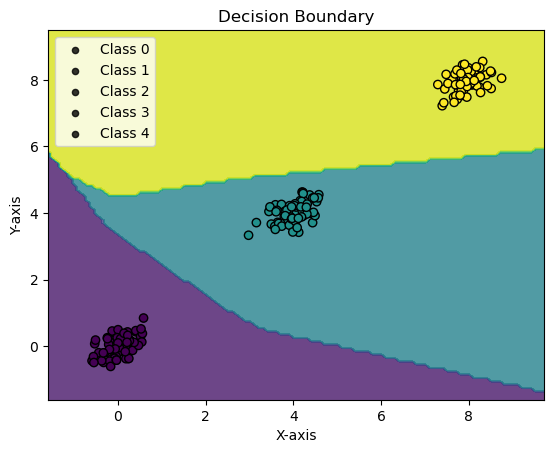

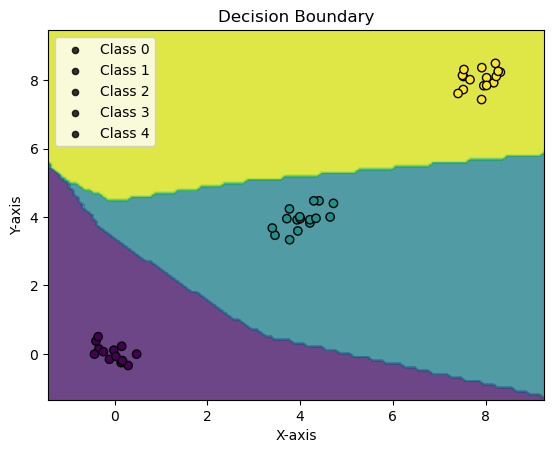

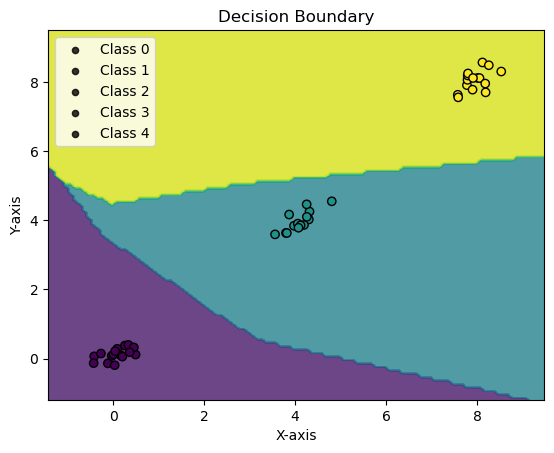

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_decision_boundary(model, X, y, n_classes):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    with torch.no_grad():
        model.eval()
        Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])).numpy()
        Z = np.argmax(Z, axis=1)

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', linewidth=1)
    plt.title("Decision Boundary")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    for i in range(n_classes):
        plt.scatter([], [], c='k', alpha=0.8, s=20, label=f"Class {i}")
    plt.legend(loc='upper left')

    plt.show()

# After training
plot_decision_boundary(model, X_primary_train, y_primary_train, n_classes)
plot_decision_boundary(model, X_primary_val, y_primary_val, n_classes)
plot_decision_boundary(model, X_primary_test, y_primary_test, n_classes)


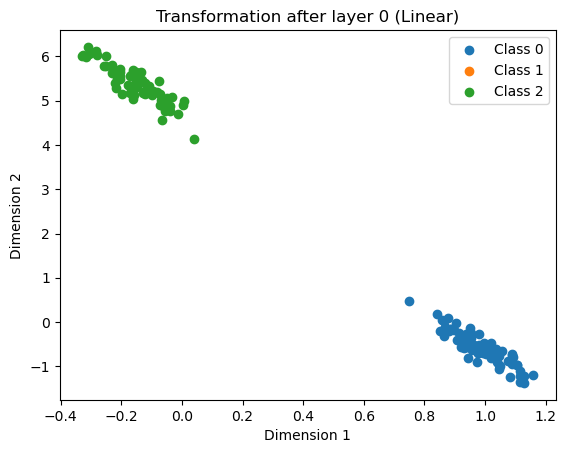

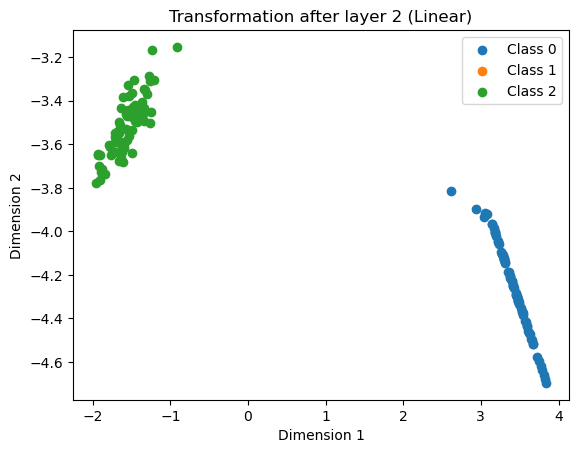

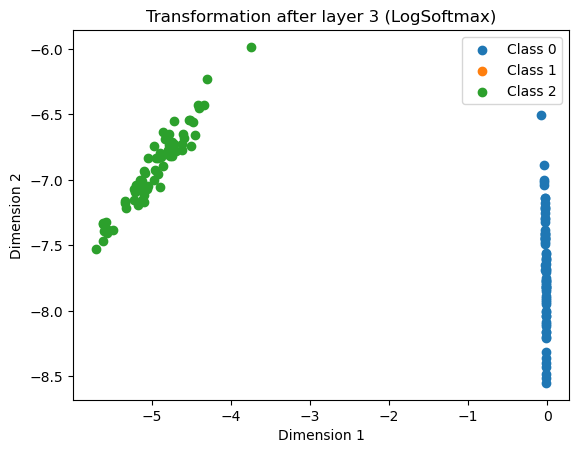

In [94]:
import matplotlib.pyplot as plt

def plot_layer_transformations(model, X, y, layer_indices):
    n_classes = len(np.unique(y))
    X_transformed = torch.FloatTensor(X)
    
    for i, layer_index in enumerate(layer_indices):
        layer = model[layer_index]
        
        with torch.no_grad():
            X_transformed = layer(X_transformed)
            
        if isinstance(layer, nn.Linear) or isinstance(layer, nn.Tanh) or isinstance(layer, nn.LogSoftmax):
            X_transformed_numpy = X_transformed.detach().cpu().numpy()
            
            plt.figure()
            for class_idx in range(n_classes):
                idxs = np.where(y == class_idx)[0]
                plt.scatter(X_transformed_numpy[idxs, 0], X_transformed_numpy[idxs, 1], label=f"Class {class_idx}")
            
            layer_type = type(layer).__name__
            plt.title(f'Transformation after layer {layer_index} ({layer_type})')
            plt.xlabel('Dimension 1')
            plt.ylabel('Dimension 2')
            plt.legend()

# Indicate which layers you are interested in (by index).
layer_indices = list(range(depth*2))

# X should be your original data and y should be the labels.
plot_layer_transformations(model, X_primary_train, y_primary_train, layer_indices)

plt.show()


In [95]:
eval(model, device, test_loader, debug=True, classification_report_flag = True)


Train set: Average loss: 0.1191, Accuracy: 46.0/46 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        16
     Class 1       1.00      1.00      1.00        14
     Class 2       1.00      1.00      1.00        16

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



1.0

In [87]:
#save model
# torch.save(model, f"model_{depth}_synthetic_data_against_overfitting.pt")

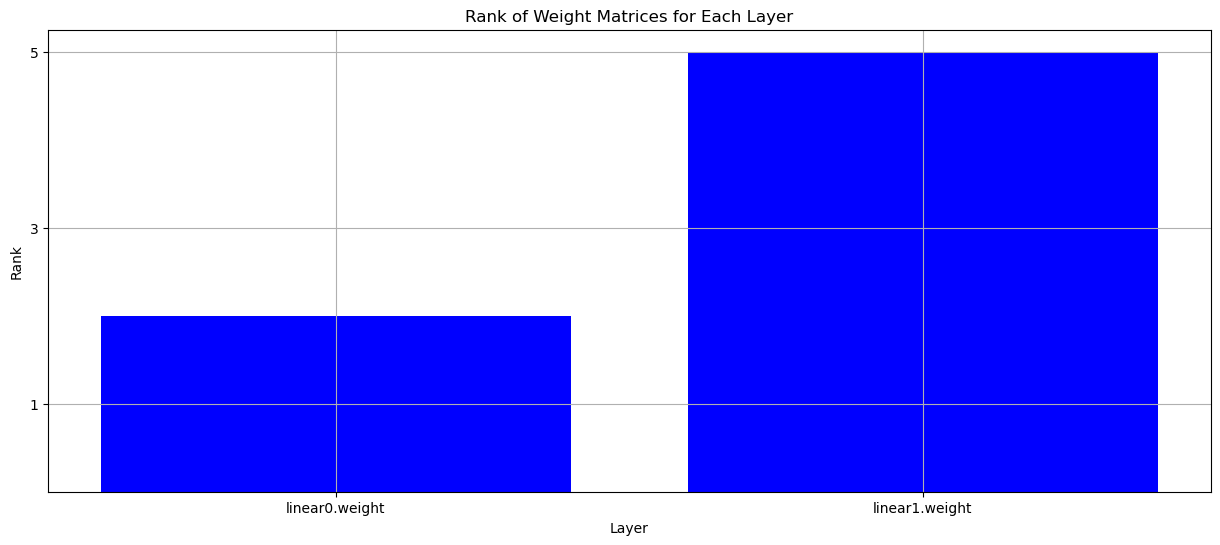

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def plot_layer_ranks(model):
    ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            rank = np.linalg.matrix_rank(weight_matrix)
            ranks.append(rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar(layer_names, ranks, color='blue')
    plt.xlabel('Layer')
    plt.ylabel('Rank')
    plt.title('Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(y_min, y_max, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


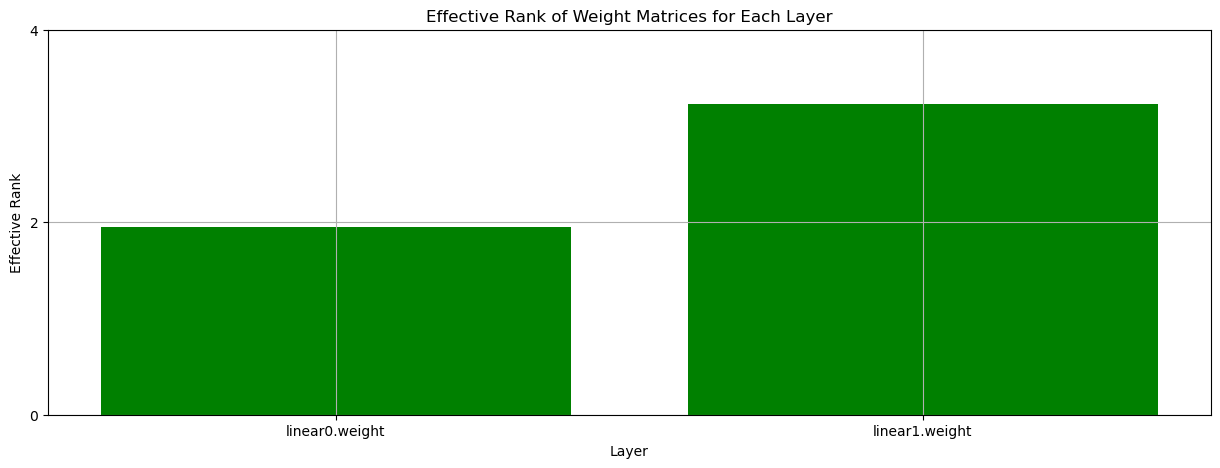

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import torch

'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model):
    effective_ranks = []
    layer_names = []
    
    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)
    
    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


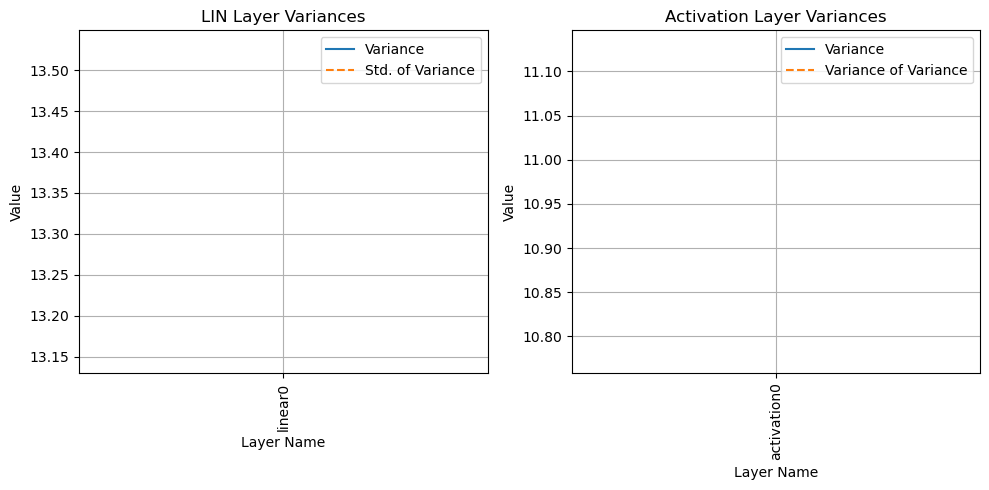

In [101]:
results, variances = compute_layer_variances_dense(model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

----

# Finetuning experiments

## Finetuning on two new classes while maintaining the old ones

In [113]:
from torch.utils.data import DataLoader, TensorDataset
import copy

# change params learning rate
params['lr'] = 0.001

def extend_model_for_new_classes(model, new_output_dim):

    new_model = copy.deepcopy(model)
    """
    Extend the model's output dimension for additional classes.
    """
    new_linear = torch.nn.Linear(new_model[-2].in_features, new_output_dim)
    new_linear.weight.data[:new_model[-2].out_features] = new_model[-2].weight.data
    new_linear.bias.data[:new_model[-2].out_features] = new_model[-2].bias.data
    
    new_model[-2] = new_linear

    return new_model

# Generate new data for additional classes
new_n_classes = 2  # Adding 2 more classes
new_shift = 2.0

# Find the maximum mean from the original data
max_original_mean = (n_classes - 1) * shift

# When generating new data, start from max_original_mean + desired_separation
desired_separation = 2.0
new_shift_start = max_original_mean + desired_separation

X_new, y_new = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)

y_new += n_classes  # Update labels for new classes

# Combine old and new data
X_combined = np.vstack([X, X_new])
y_combined = np.concatenate([y, y_new])

# Shuffle the combined dataset
shuffle_indices = np.random.permutation(len(X_combined))
X_combined = X_combined[shuffle_indices]
y_combined = y_combined[shuffle_indices]

X_combined_train = X_combined[:int(len(X_combined)*0.7)]
y_combined_train = y_combined[:int(len(y_combined)*0.7)]
X_combined_test = X_combined[int(len(X_combined)*0.7):]
y_combined_test = y_combined[int(len(y_combined)*0.7):]

# Convert to PyTorch tensors
X_tensor_combined_train = torch.FloatTensor(X_combined_train)
y_tensor_combined_train = torch.LongTensor(y_combined_train)
X_tensor_combined_test = torch.FloatTensor(X_combined_test)
y_tensor_combined_test = torch.LongTensor(y_combined_test)

# Create DataLoader for combined data
dataset_combined = TensorDataset(X_tensor_combined_train, y_tensor_combined_train)
dataset_test_combined = TensorDataset(X_tensor_combined_test, y_tensor_combined_test)
train_loader_combined = DataLoader(dataset_combined, batch_size=32, shuffle=True)
#test_loader_combined = DataLoader(dataset_combined, batch_size=32, shuffle=False)
test_loader_combined = DataLoader(dataset_test_combined, batch_size=32, shuffle=False)

# Update the model for the new classes
new_output_dim = n_classes + new_n_classes  # Original classes + new classes
finetuned_all_classes_model = extend_model_for_new_classes(model, new_output_dim)

# Update params and dataset namespace for new classes
params['depth'] = depth  # Make sure to set the correct depth
dataset_namespace_combined = SimpleNamespace(train_loader=train_loader_combined, test_loader=test_loader_combined, val_loader=test_loader_combined)

# Fine-tune and evaluate on new dataset
train_acc, test_acc, finetuned_all_classes_model, _ = compute_training_acc_epochs(finetuned_all_classes_model, dataset_namespace_combined, params, debug=True)

print(f"Fine-tuned Training Accuracy: {train_acc:.4f}")
print(f"Fine-tuned Test Accuracy: {test_acc:.4f}")


Epoch: 0 	Training Accuracy: 57.46%
Validation Accuracy: 55.92%
Epoch: 1 	Training Accuracy: 73.01%
Validation Accuracy: 67.30%
Epoch: 2 	Training Accuracy: 77.91%
Validation Accuracy: 74.88%
Epoch: 3 	Training Accuracy: 83.03%
Validation Accuracy: 77.73%
Epoch: 4 	Training Accuracy: 63.60%
Validation Accuracy: 62.09%
val_acc: 0.6208530805687204, max_val_acc: 0.7772511848341233, no_improve_epochs: 1
Epoch: 5 	Training Accuracy: 86.91%
Validation Accuracy: 81.52%
Epoch: 6 	Training Accuracy: 87.53%
Validation Accuracy: 81.52%
val_acc: 0.8151658767772512, max_val_acc: 0.8151658767772512, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 75.66%
Validation Accuracy: 72.04%
val_acc: 0.7203791469194313, max_val_acc: 0.8151658767772512, no_improve_epochs: 2
Epoch: 8 	Training Accuracy: 87.12%
Validation Accuracy: 81.52%
val_acc: 0.8151658767772512, max_val_acc: 0.8151658767772512, no_improve_epochs: 3
Epoch: 9 	Training Accuracy: 87.53%
Validation Accuracy: 81.52%
val_acc: 0.8151658767772512,

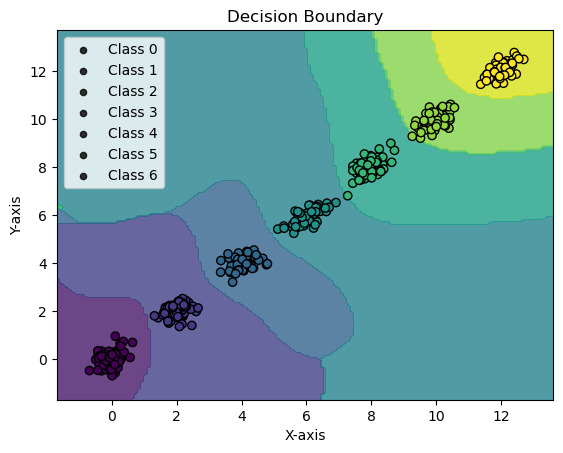


Train set: Average loss: 0.2160, Accuracy: 211.0/211 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        25
     Class 1       1.00      1.00      1.00        29
     Class 2       1.00      1.00      1.00        34
     Class 3       1.00      1.00      1.00        31
     Class 4       1.00      1.00      1.00        30
     Class 5       1.00      1.00      1.00        23
     Class 6       1.00      1.00      1.00        39

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



1.0

In [114]:
plot_decision_boundary(finetuned_all_classes_model, X_combined_train, y_combined_train, n_classes + new_n_classes)
eval(finetuned_all_classes_model, device, test_loader_combined, debug=True)

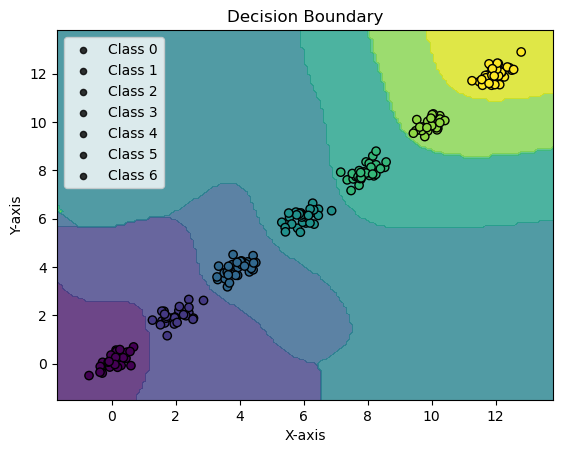


Train set: Average loss: 0.2160, Accuracy: 211.0/211 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        25
     Class 1       1.00      1.00      1.00        29
     Class 2       1.00      1.00      1.00        34
     Class 3       1.00      1.00      1.00        31
     Class 4       1.00      1.00      1.00        30
     Class 5       1.00      1.00      1.00        23
     Class 6       1.00      1.00      1.00        39

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



1.0

In [115]:
plot_decision_boundary(finetuned_all_classes_model, X_combined_test, y_combined_test, n_classes + new_n_classes)
eval(finetuned_all_classes_model, device, test_loader_combined, debug=True)

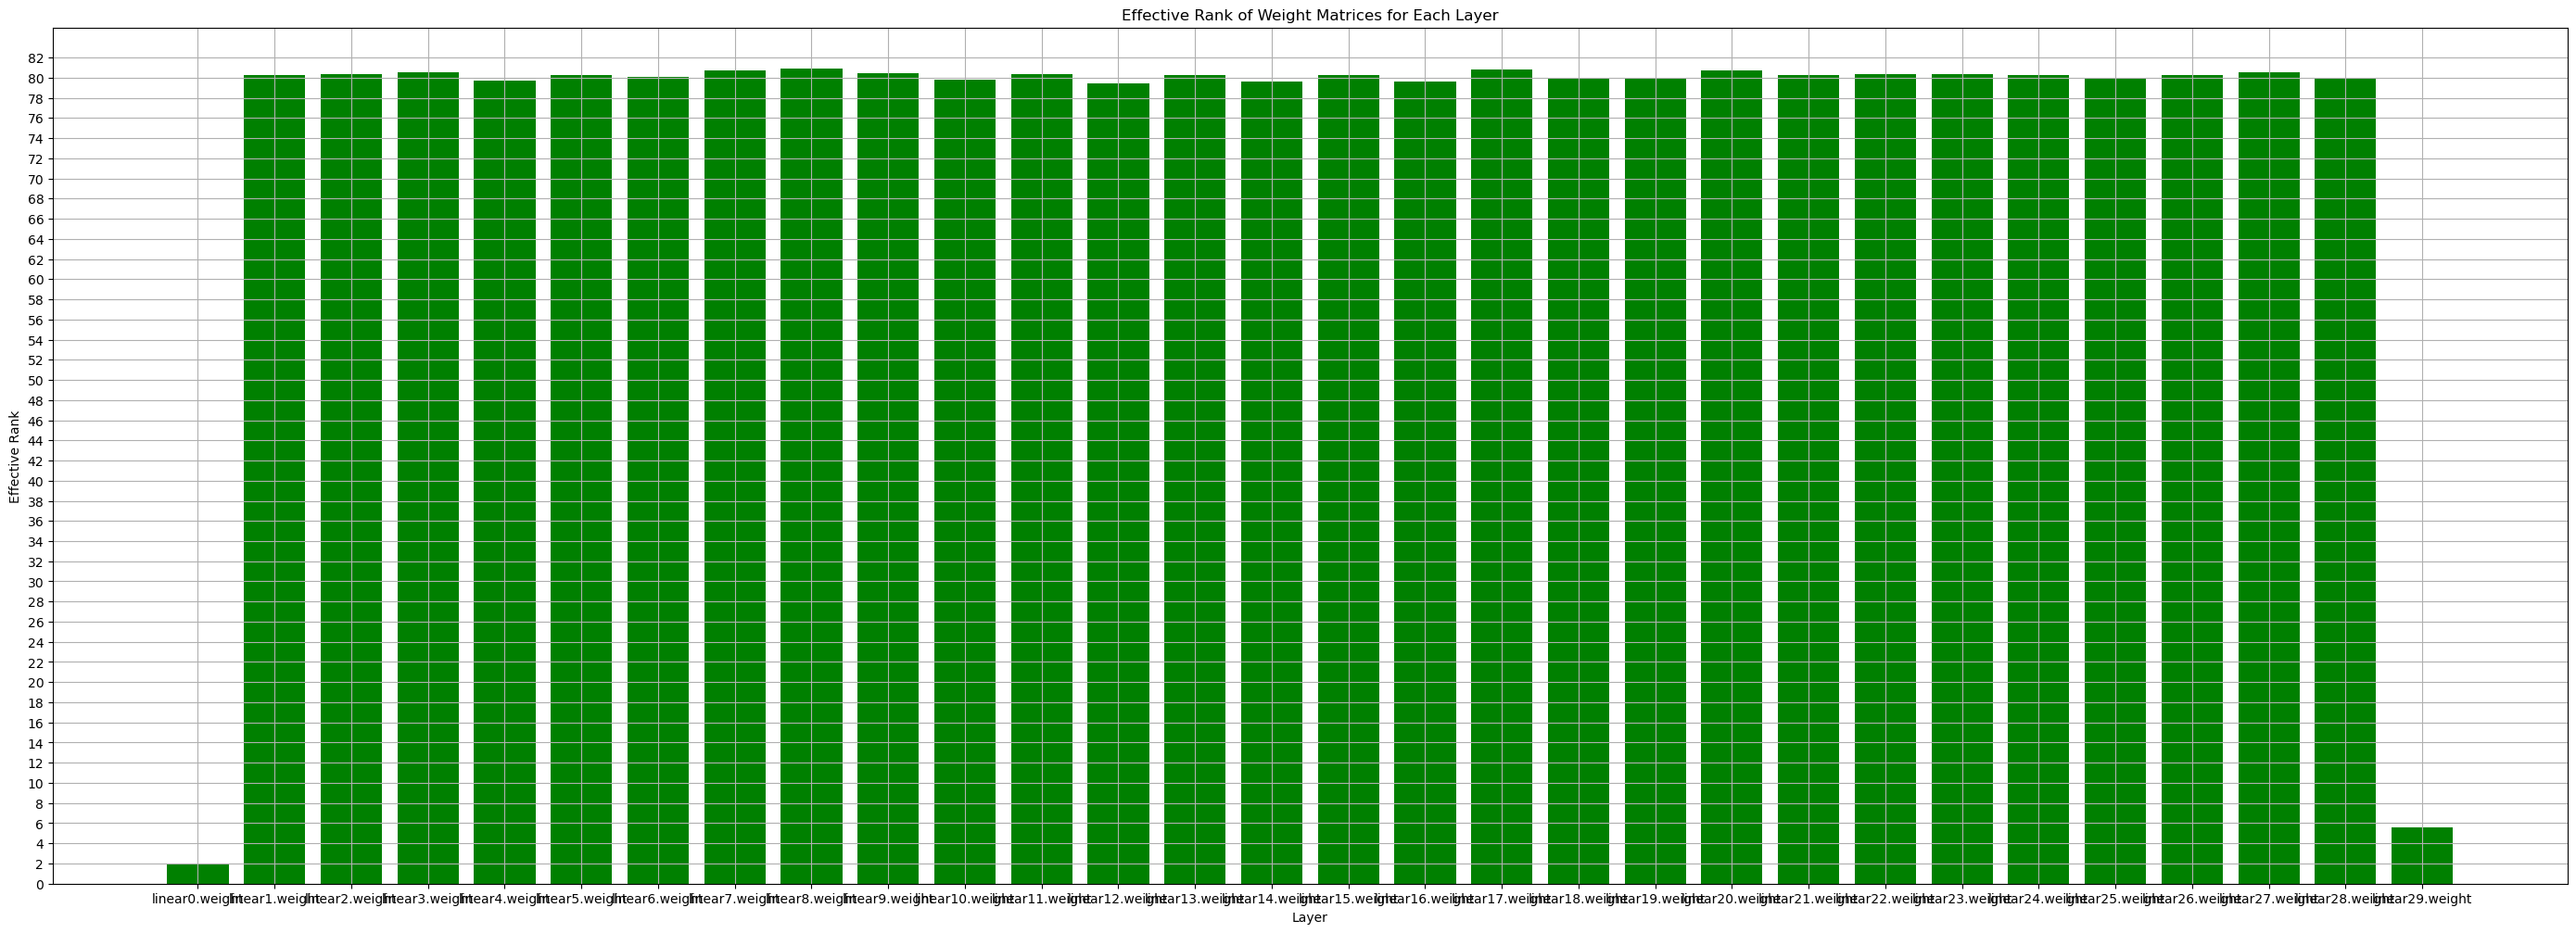

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


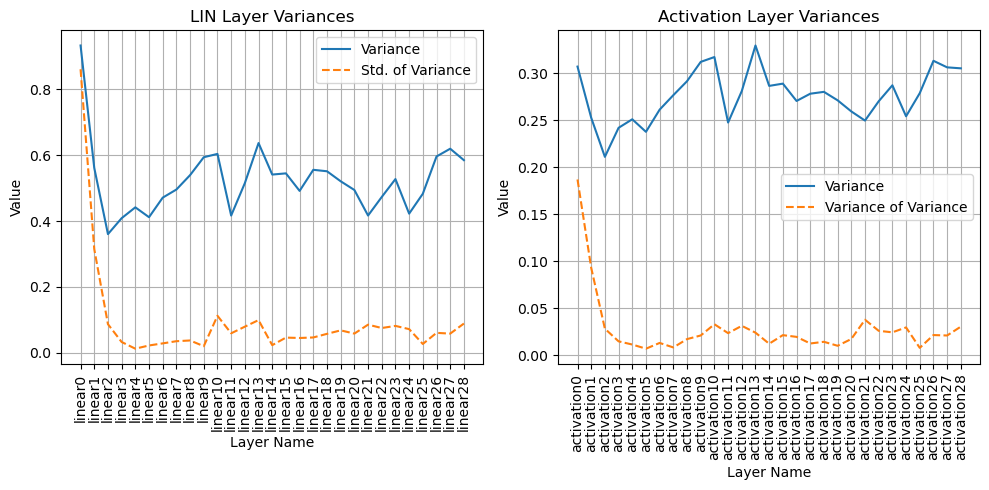

In [116]:
plot_layer_effective_ranks(finetuned_all_classes_model)
results, variances = compute_layer_variances_dense(finetuned_all_classes_model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

----

### Same dataset, trained from scratch

Epoch: 0 	Training Accuracy: 58.49%
Validation Accuracy: 51.66%
Epoch: 1 	Training Accuracy: 45.60%
Validation Accuracy: 36.49%
val_acc: 0.36492890995260663, max_val_acc: 0.5165876777251185, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 55.62%
Validation Accuracy: 59.24%
Epoch: 3 	Training Accuracy: 51.74%
Validation Accuracy: 45.97%
val_acc: 0.4597156398104265, max_val_acc: 0.5924170616113744, no_improve_epochs: 1
Epoch: 4 	Training Accuracy: 85.69%
Validation Accuracy: 85.78%
Epoch: 5 	Training Accuracy: 86.91%
Validation Accuracy: 81.04%
val_acc: 0.8104265402843602, max_val_acc: 0.8578199052132701, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 62.37%
Validation Accuracy: 67.77%
val_acc: 0.6777251184834123, max_val_acc: 0.8578199052132701, no_improve_epochs: 2
Epoch: 7 	Training Accuracy: 85.48%
Validation Accuracy: 85.78%
val_acc: 0.8578199052132701, max_val_acc: 0.8578199052132701, no_improve_epochs: 3
Epoch: 8 	Training Accuracy: 97.14%
Validation Accuracy: 95.73%
Epoch: 9

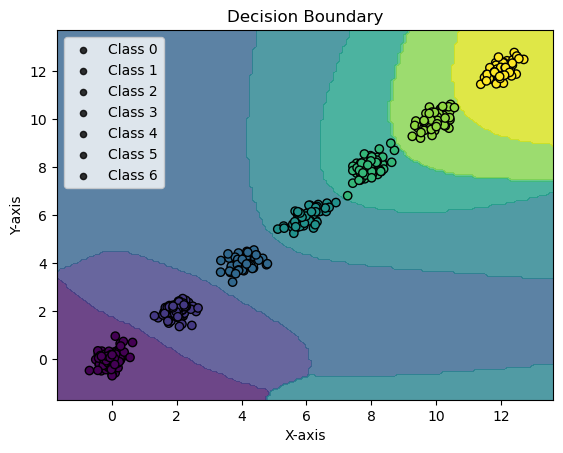


Train set: Average loss: 0.0442, Accuracy: 211.0/211 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        25
     Class 1       1.00      1.00      1.00        29
     Class 2       1.00      1.00      1.00        34
     Class 3       1.00      1.00      1.00        31
     Class 4       1.00      1.00      1.00        30
     Class 5       1.00      1.00      1.00        23
     Class 6       1.00      1.00      1.00        39

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



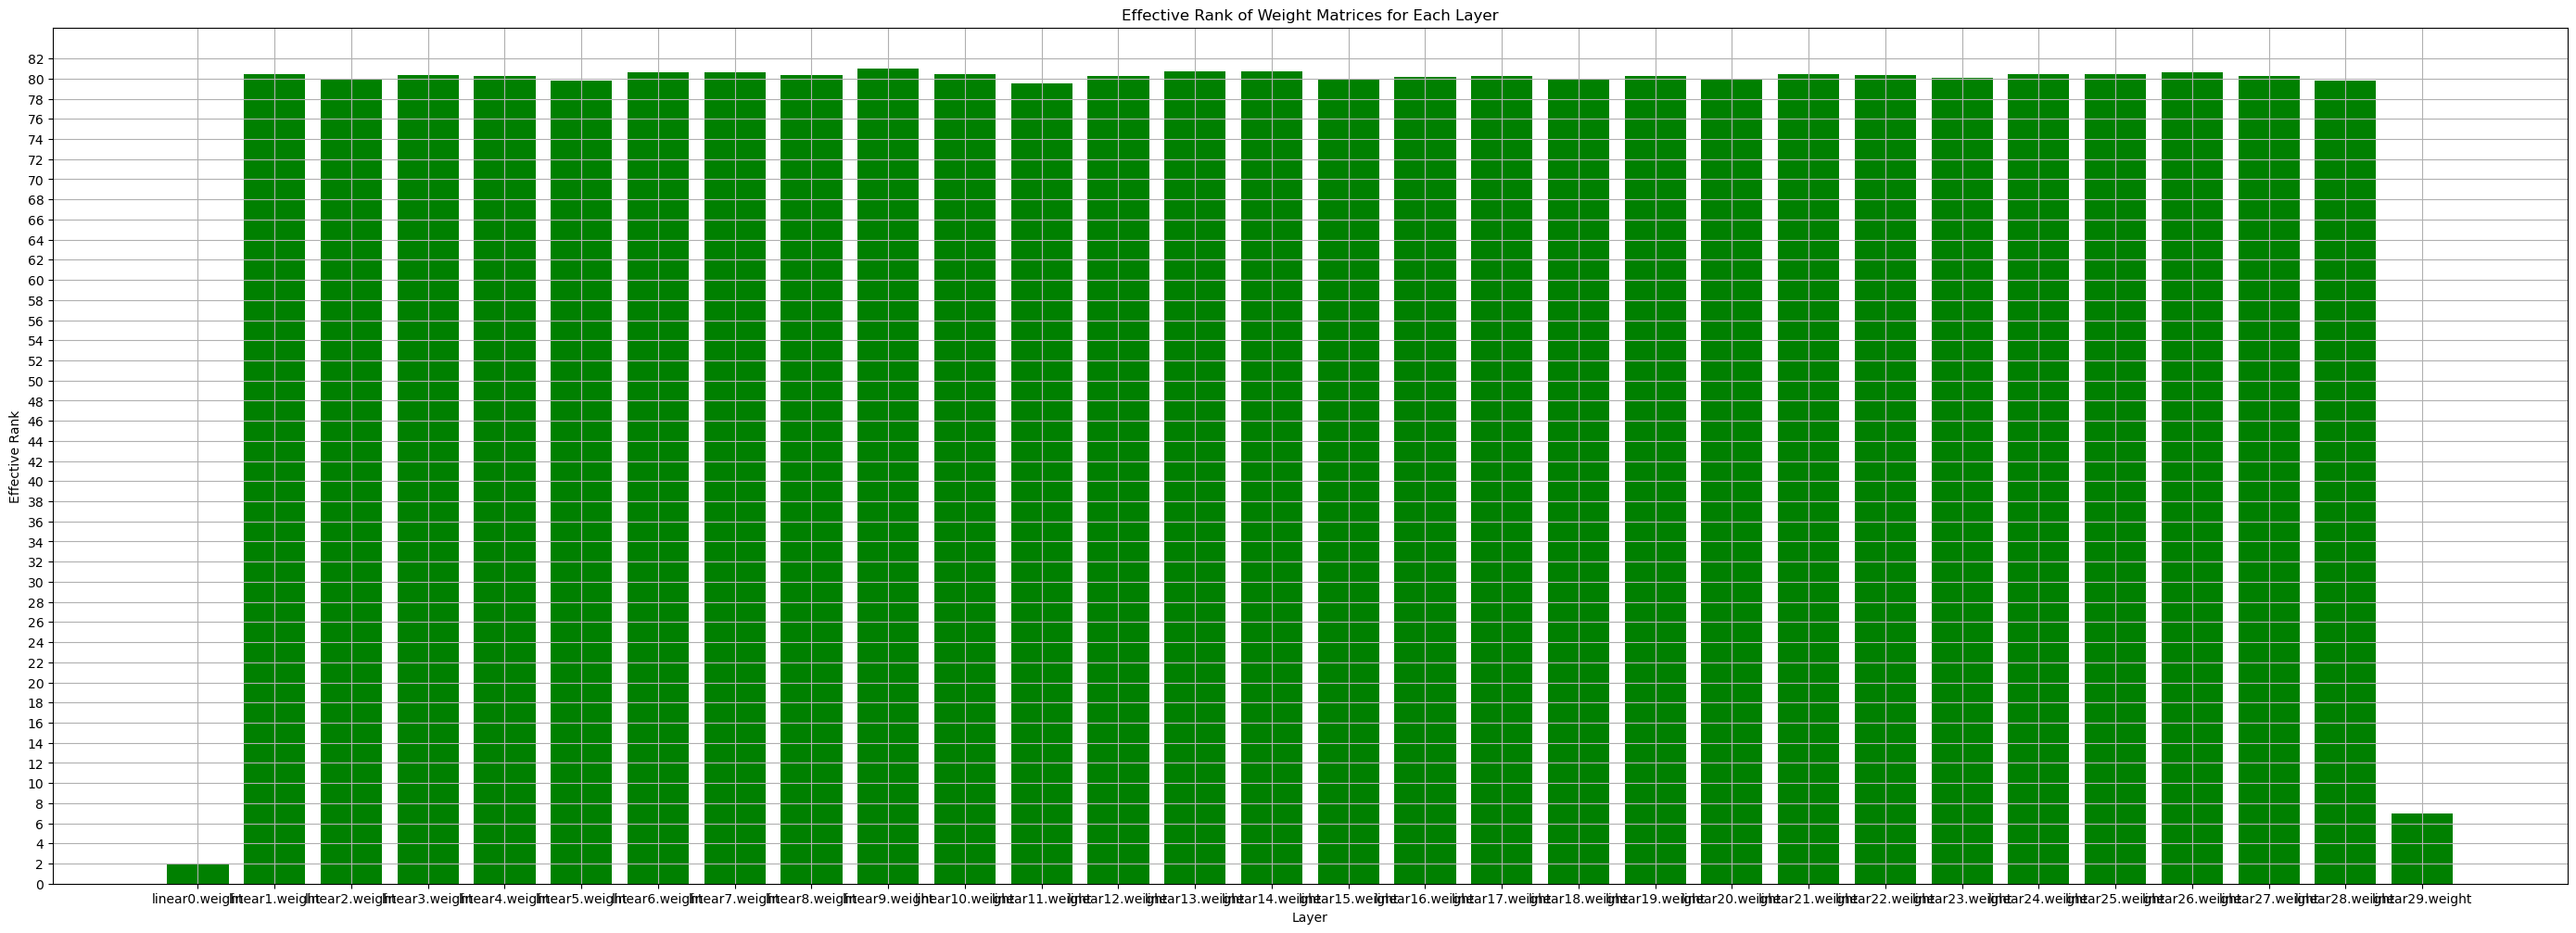

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


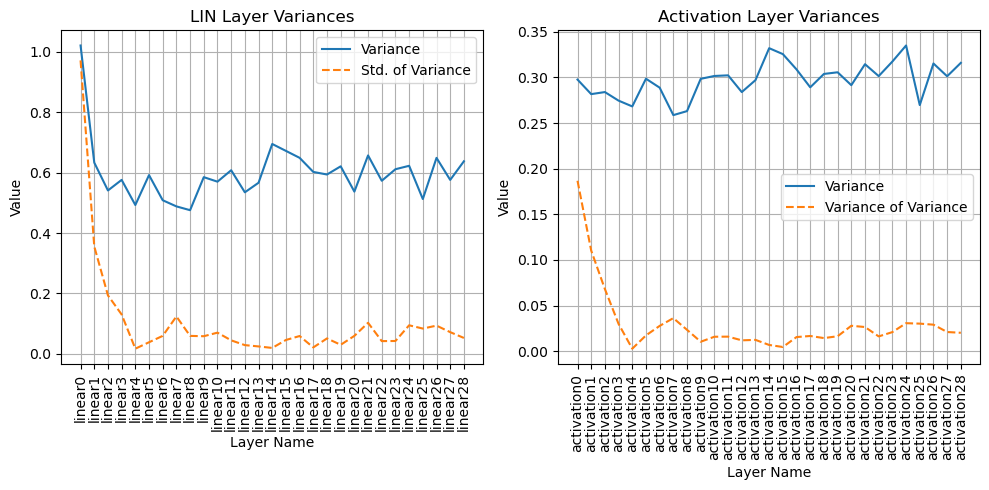

In [118]:
end2end_all_classes_model = generate_fc_dnn(input_dim, new_output_dim, params, gaussian_init= True)
train_acc, test_acc, end2end_all_classes_model, _ = compute_training_acc_epochs(end2end_all_classes_model, dataset_namespace_combined, params, debug=True)

plot_decision_boundary(end2end_all_classes_model, X_combined_train, y_combined_train, n_classes + new_n_classes)

eval(end2end_all_classes_model, device, test_loader_combined, debug=True)

plot_layer_effective_ranks(end2end_all_classes_model)

results, variances = compute_layer_variances_dense(end2end_all_classes_model, test_loader, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )


## Finetuning on three new classes while not using the old ones

In [129]:
# 1. Generate new classes without overlapping the previous ones

# change params learning rate
params['lr'] = 0.0001

new_n_classes = 3  # E.g., generate 3 new classes
max_original_mean = (n_classes - 1) * shift
desired_separation = 2.0
new_shift_start = max_original_mean + desired_separation

X_new, y_new = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)
X_new_test, y_new_test = generate_data(new_n_classes, n_points, base_covariance, shift, new_shift_start)

# Convert to PyTorch tensors
X_tensor_new = torch.FloatTensor(X_new)
y_tensor_new = torch.LongTensor(y_new)  # Since it's only new classes, the labels start from 0 again

# Create DataLoader for new data
dataset_new = TensorDataset(X_tensor_new, y_tensor_new)
train_loader_new = DataLoader(dataset_new, batch_size=32, shuffle=True)
test_loader_new = DataLoader(TensorDataset(torch.FloatTensor(X_new_test), torch.LongTensor(y_new_test)), batch_size=32, shuffle=False)

# 2. Create a new model and copy weights from the original model, then adjust the final layer

model_new = generate_fc_dnn(input_dim, new_n_classes, params)

# Manually copy weights from the original model to the new model for all layers except the final one
for name, param in model.named_parameters():
    if "linear" + str(depth-1) not in name:  # This is to exclude the final layer
        model_new._parameters[name] = param

# 3. Fine-tune on the new data

dataset_namespace_new = SimpleNamespace(train_loader=train_loader_new, test_loader=test_loader_new, val_loader=test_loader_new)

# Train and evaluate the new model on the new data
train_acc_new, test_acc_new, model_new, _ = compute_training_acc_epochs(model_new, dataset_namespace_new, params, debug=True)

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")



Epoch: 0 	Training Accuracy: 40.33%
Validation Accuracy: 40.33%
Epoch: 1 	Training Accuracy: 41.00%
Validation Accuracy: 40.67%
Epoch: 2 	Training Accuracy: 34.00%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.4066666666666667, no_improve_epochs: 1
Epoch: 3 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.4066666666666667, no_improve_epochs: 2
Epoch: 4 	Training Accuracy: 47.67%
Validation Accuracy: 45.33%
Epoch: 5 	Training Accuracy: 39.33%
Validation Accuracy: 38.67%
val_acc: 0.38666666666666666, max_val_acc: 0.4533333333333333, no_improve_epochs: 1
Epoch: 6 	Training Accuracy: 92.67%
Validation Accuracy: 92.00%
Epoch: 7 	Training Accuracy: 68.33%
Validation Accuracy: 71.33%
val_acc: 0.7133333333333334, max_val_acc: 0.92, no_improve_epochs: 1
Epoch: 8 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.92, no_improve_epochs: 2
Epoch: 9 	Training Accuracy: 33.33%


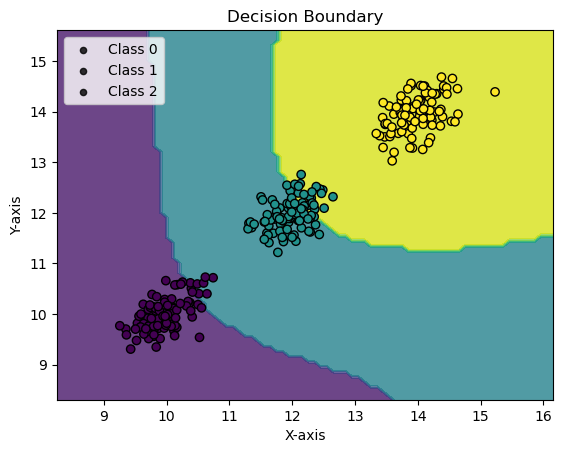


Train set: Average loss: 0.3152, Accuracy: 269.0/300 (90%)

              precision    recall  f1-score   support

     Class 0       1.00      0.92      0.96       100
     Class 1       0.91      0.77      0.83       100
     Class 2       0.81      1.00      0.90       100

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300



0.8966666666666666

In [130]:
plot_decision_boundary(model_new, X_new_test, y_new_test, new_n_classes)
eval(model_new, device, test_loader_new, debug=True)

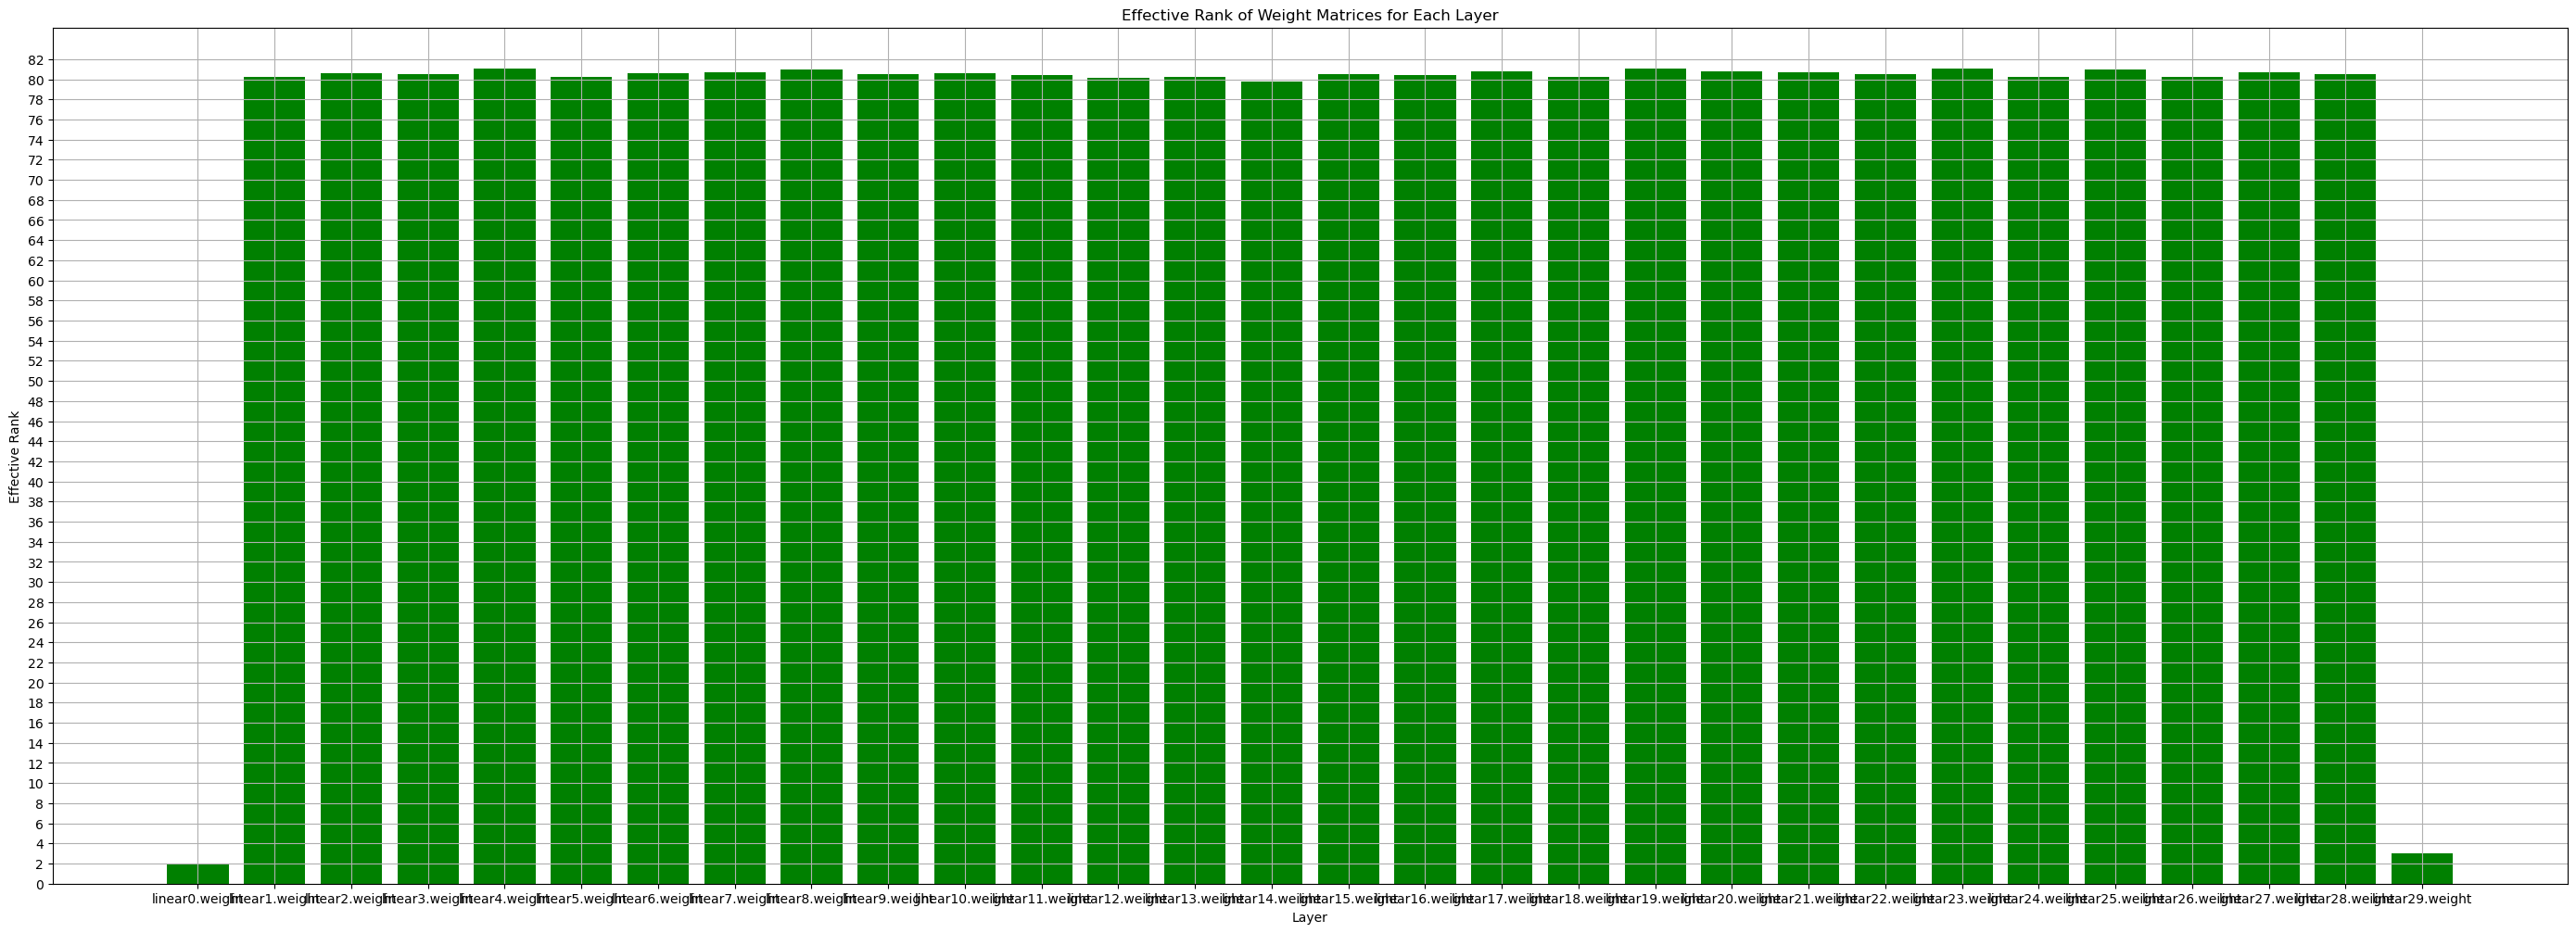

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


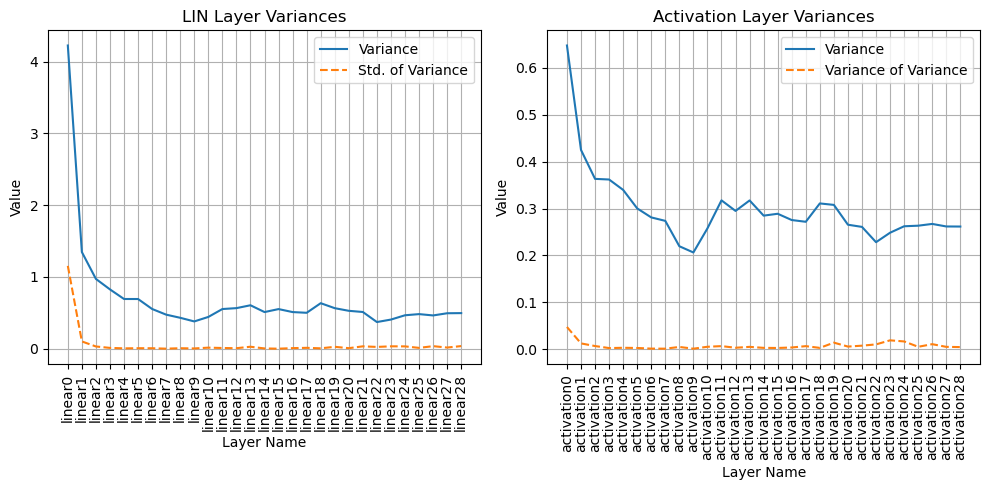

In [131]:
plot_layer_effective_ranks(model_new)
results, variances = compute_layer_variances_dense(model_new, test_loader_new, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )

----

### Same dataset, trained from scratch

Epoch: 0 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
Epoch: 1 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.3333333333333333, no_improve_epochs: 1
Epoch: 2 	Training Accuracy: 33.33%
Validation Accuracy: 33.33%
val_acc: 0.3333333333333333, max_val_acc: 0.3333333333333333, no_improve_epochs: 2
Epoch: 3 	Training Accuracy: 65.00%
Validation Accuracy: 64.67%
Epoch: 4 	Training Accuracy: 66.67%
Validation Accuracy: 65.67%
Epoch: 5 	Training Accuracy: 67.33%
Validation Accuracy: 66.33%
Epoch: 6 	Training Accuracy: 52.67%
Validation Accuracy: 56.00%
val_acc: 0.56, max_val_acc: 0.6633333333333333, no_improve_epochs: 1
Epoch: 7 	Training Accuracy: 66.67%
Validation Accuracy: 67.33%
Epoch: 8 	Training Accuracy: 66.67%
Validation Accuracy: 67.00%
val_acc: 0.67, max_val_acc: 0.6733333333333333, no_improve_epochs: 1
Epoch: 9 	Training Accuracy: 60.00%
Validation Accuracy: 60.00%
val_acc: 0.6, max_val_acc: 0.6733333333333333, no_improv

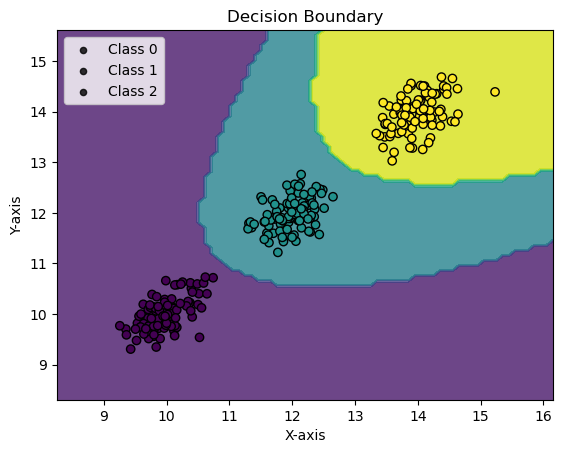


Train set: Average loss: 0.1770, Accuracy: 300.0/300 (100%)

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       100
     Class 1       1.00      1.00      1.00       100
     Class 2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



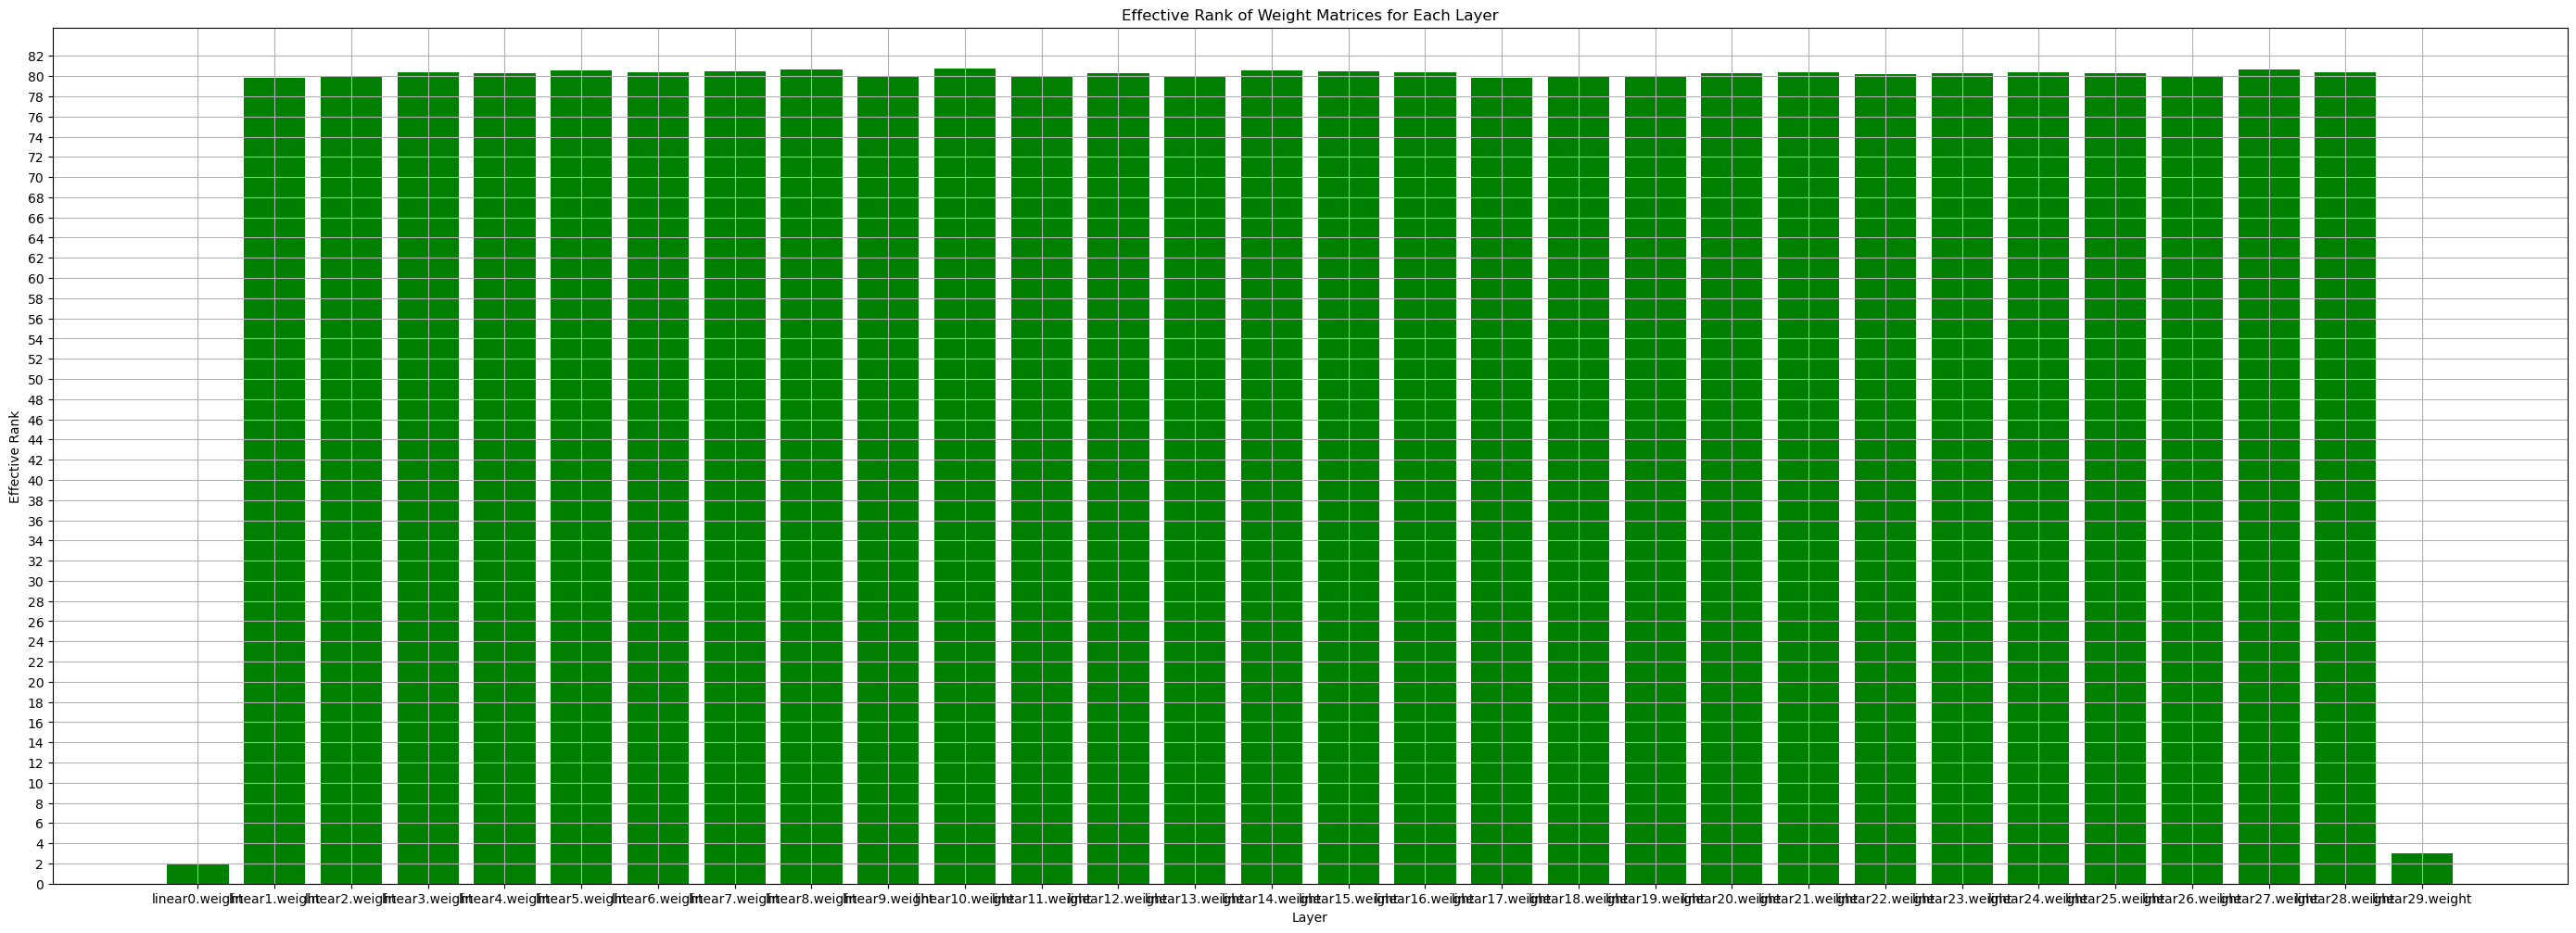

/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:103: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(conv_layer_names, rotation=90)
/Users/davidguzman/Documents/GitHub/mp-tl-study/David/../plots.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(activation_layer_names, rotation=90)


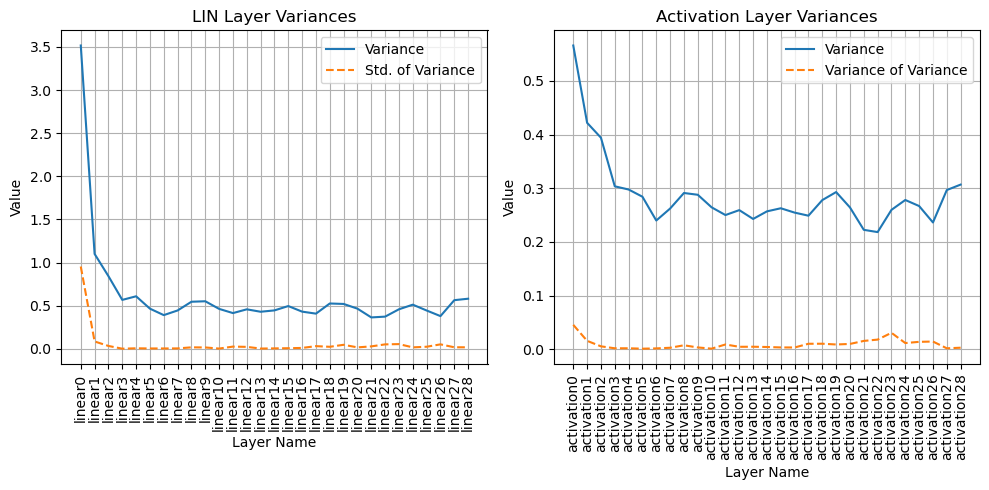

In [149]:
params['lr'] = 0.0001

end2end_new_classes_model = generate_fc_dnn(input_dim, new_n_classes, params, gaussian_init= True)
train_acc, test_acc, end2end_new_classes_model, _ = compute_training_acc_epochs(end2end_new_classes_model, dataset_namespace_new, params, debug=True)

plot_decision_boundary(end2end_new_classes_model, X_new_test, y_new_test, new_n_classes)
eval(end2end_new_classes_model, device, test_loader_new, debug=True)

plot_layer_effective_ranks(end2end_new_classes_model)

results, variances = compute_layer_variances_dense(end2end_new_classes_model, test_loader_new, device = 'cpu',cnn=False)
plot_variances_by_layer_type(variances, results, cnn = False, ignore_final_layer=True, std_of_variance = True )
